# 1.  U-Net trained on the MoNuSeg data set
This notebook is for training a model on the data from the MonSeg challenge. The goal is to train a model that will be used to find cell instances in the data from the SweBCH91RT study.

In [1]:
import random
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras

import wandb
from wandb.keras import WandbCallback

from weighted_loss_unet import make_weighted_loss_unet, my_loss
from augmented_sequence import AugmentedSequence

import config
import importlib
importlib.reload(config)
c = config.Config()

## Data augmentation

In [2]:
seq = iaa.Sequential([
    iaa.CropToFixedSize(width=round(c.WIDTH*4.0), height=round(c.HEIGHT*4.0)),
    iaa.flip.Flipud(p=0.25),
    iaa.flip.Fliplr(p=0.25),
    iaa.Affine(rotate=(0,360),
               scale={"x":(0.8, 1.2), "y":(0.8, 1.2)},
               shear=(-8, 8)),
    iaa.CropToFixedSize(width=c.WIDTH, height=c.HEIGHT, position="center"),
    iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 1.0))),
    iaa.AddToHue((-25, 25))
    #iaa.Sometimes(0.2, iaa.EdgeDetect((0,0.5)))
])

val_sequential = iaa.Sequential([
    iaa.CropToFixedSize(width=c.WIDTH, height=c.HEIGHT, position="center"),
])

from dataset import Monuseg, Bns, Quip
#train1, test= Bns().make_split()
#train1, val1= train1.make_split()

#train, test= Quip().make_split()
#train, val= train2.make_split()
train = Quip()
train.ids = train.ids[:10]
val = train


train_seq = AugmentedSequence([train], seq)
val_seq = AugmentedSequence([val], val_sequential)

Indexing annotations in /tank/data/arvid/SweBCG91RT-Net/data/quip/annotations


## Sanity check

(9, 256, 256, 3) (9, 256, 256, 3) (9, 256, 256, 3)
uint8 float32 float32
[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.99999994 1.         0.99999994 ... 1.         1.         1.        ]
 [1.0000001  1.         1.0000001  ... 0.99999994 0.99999994 1.        ]
 ...
 [1.         1.         1.         ... 1.0000001  1.         1.0000001 ]
 [1.0000001  0.99999994 0.99999994 ... 1.         1.         0.99999994]
 [1.         1.0000001  1.         ... 1.         0.99999994 1.        ]]


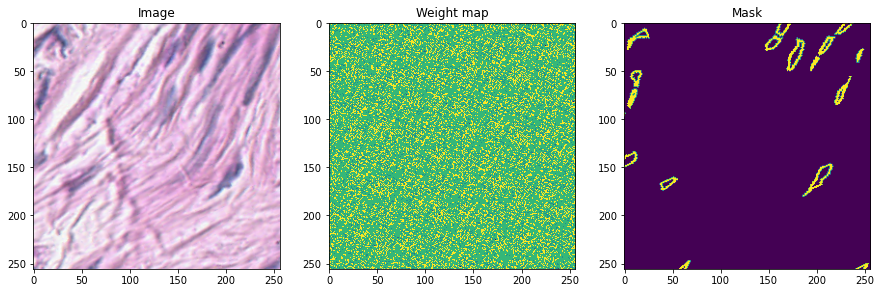

<Figure size 720x720 with 0 Axes>

In [17]:
(img_b, wmap_b), mask_b = train_seq[4]
print(img_b.shape, wmap_b.shape, mask_b.shape)
print(img_b.dtype, wmap_b.dtype, mask_b.dtype)
img = img_b[0]
wmap = wmap_b[0,...,2]
mask = mask_b[0,...,2]
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(img)
plt.title("Image")
plt.subplot(132)
plt.imshow(wmap)
plt.title("Weight map")
plt.subplot(133)
plt.imshow(mask)
plt.title("Mask")
plt.figure(figsize=(10,10))

## Train U-Net
The U-Net, along with the weight map loss function, was implemented by [jaidevd](https://jaidevd.github.io/posts/weighted-loss-functions-for-instance-segmentation/).

In [18]:
def iou(y_true, y_pred):
    y_true = y_true[0]
    intersection = K.sum(K.abs(y_true[...,1] * y_pred[...,1]), axis=-1)
    union = K.sum(K.abs(y_true[...,1]) + K.abs(y_pred[...,1]), axis=-1)
    jac = (intersection) / (union)
    return (1-jac)

In [ ]:
#tf.compat.v1.disable_eager_execution()
name = f"unet_quip_{c.EPOCHS}"
model_dir = '../models/unet'
os.makedirs(model_dir, exist_ok=True)
if f"{name}.h5" in os.listdir(model_dir):
    print("Loading existing model...", end='')
    model = keras.models.load_model(f'{model_dir}/{name}.h5',
                        custom_objects={'my_loss' : my_loss, 'iou': iou})
    print("Done!")
else:
    wandb.init(project="swebcg91rt-net")
    model = make_weighted_loss_unet(is_training = True)
    model.compile(optimizer='adam', loss=my_loss)
    model.fit(train_seq, validation_data=val_seq, epochs=c.EPOCHS, callbacks=[WandbCallback()]) 
    
    model.save(os.path.join(wandb.run.dir, "model.h5"))
    # Our inference model won't take a weight map as an input.
    model_inference = make_weighted_loss_unet(is_training = False)
    model_inference.set_weights(model.get_weights())
    model_inference.save(f'{model_dir}/{name}.h5')
    model = model_inference

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/400
10/10 [==============================] - 42s 4s/step - loss: 0.5003 - val_loss: 0.1475
Epoch 2/400
10/10 [==============================] - 50s 5s/step - loss: 0.1599 - val_loss: 0.1426
Epoch 3/400
10/10 [==============================] - 47s 5s/step - loss: 0.1301 - val_loss: 0.1354
Epoch 4/400
10/10 [==============================] - 47s 5s/step - loss: 0.1596 - val_loss: 0.1572
Epoch 5/400
10/10 [==============================] - 47s 5s/step - loss: 0.1425 - val_loss: 0.1235
Epoch 6/400
10/10 [==============================] - 47s 5s/step - loss: 0.1143 - val_loss: 0.1108
Epoch 7/400
 1/10 [==>...........................] - ETA: 0s - loss: 0.0586

# Post-processing
We use some of the techniques found in the [NucleAIzer Paper](https://www.sciencedirect.com/science/article/pii/S2405471220301174).
1. Descide on optimal threshold.
2. Remove small holes.
3. Remove small objects.

In [6]:
import skimage.morphology as morphology
from scipy.optimize import minimize

def post_processing(prediction, p):
    prediction = (prediction > p[0])
    prediction = morphology.remove_small_holes(prediction, area_threshold=10*p[1])
    prediction = morphology.remove_small_objects(prediction, min_size=10*p[2])
    prediction = morphology.dilation(prediction, morphology.square(6))
    return prediction

def make_sequence(patient_ids):
    """ Making a regular sequence without any augmentations. """
    crop_seq = iaa.Sequential([iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT)])
    return AugmentedSequence(patient_ids, BATCH_SIZE, crop_seq, IMG_WIDTH, IMG_HEIGHT)

def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union

def mean_iou(y_true: list, y_pred : list):
    return np.mean([iou(yt, yp) for yt, yp in zip(y_true, y_pred)])

img_batches, y_true_batches = zip(*[(img_b, mask_b) for (img_b, _), mask_b in val_seq])
y_pred_batches = [model.predict(img_b) for img_b in img_batches]

y_true = [y[...,1] + y[...,2] for batch in y_true_batches for y in batch ]
y_pred = [y[...,1] for batch in y_pred_batches for y in batch ]

def loss(p):
    return - mean_iou(y_true, [post_processing(y, p) for y in y_pred])

In [7]:
# Optimize post-processing parameters
p = [0.7, 4, 5]
p_optimal = minimize(loss, p, method='Nelder-Mead', options={'disp':True})
p = p_optimal["x"]
print(p)

<ipython-input-6-814d66ed40ed>:19: RuntimeWarning: invalid value encountered in long_scalars
  return intersection / union


KeyboardInterrupt: 

In [ ]:
n=1
plt.figure(figsize=(9,5))
plt.subplot(131)
plt.imshow(y_pred[n])
plt.subplot(132)
plt.imshow(post_processing(y_pred[n], p))
plt.subplot(133)
plt.imshow(y_true[n])

# Predict of validation set

In [ ]:
def display_result(model, aug_sequence, batch_limit=1):
    for n, ((img_b, _), mask_b) in enumerate(aug_sequence):
        if n > batch_limit:
            break
        prediction = model.predict(img_b)
        for img, mask, pred in zip(img_b, mask_b, prediction):
            y_true = mask[:,:,1] + mask[...,2]
            plt.figure(figsize=(15,8))
            plt.subplot(141)
            plt.imshow(img)
            plt.title("Image")
        
            plt.subplot(142)
            plt.imshow(y_true)
            plt.title("Ground Truth")

            plt.subplot(143)
            plt.imshow(pred[:,:,1])
            plt.title("Predicted")
            
            plt.subplot(144)
            pred = post_processing(pred[...,1], p)
            intersection = np.logical_and(y_true, pred).sum()
            union = np.logical_or(y_true, pred).sum()
            iou = round(intersection / union, 2)
            plt.imshow(pred)
            plt.title(f"IoU: {iou}")
           

p = [0.6, 20, 0]
display_result(model, train_seq)

# Predict on Swebcg set

In [ ]:
import dataset
from dataset import Swebcg
from tqdm import tqdm
swebcg = Swebcg()
        
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield np.array(lst[i:i + n])
        
swebcg_sequential = iaa.Sequential([
    iaa.CropToFixedSize(width=int(c.WIDTH/2), height=int(c.HEIGHT/2), position="center"),
    iaa.Resize({"height" : c.HEIGHT,  "width" : c.WIDTH})
])
    
images = [swebcg.load_image(pid) for pid in swebcg.ids[0:10]]
for img_b in chunks(swebcg_sequential(images=images), c.BATCH_SIZE):
    prediction = model.predict(img_b)
    for img, pred in zip(img_b, prediction):
        plt.figure(figsize=(15,8))
        plt.subplot(131)
        plt.imshow(img)
        plt.title("Image")

        plt.subplot(132)
        plt.imshow(pred[:,:,1])
        plt.title("Predicted")
        
        plt.subplot(133)
        pred = post_processing(pred[...,1], p)
        plt.imshow(pred)
        plt.title("Processed")
